# IMA 205 Challenge
## Cardiac Pathology Prediction

*Author: Benjamin TERNOT*

### I. Imports and basic functions

In [56]:
import numpy as np

from copy import deepcopy

from tqdm.notebook import tqdm

import nibabel as nib

import os
import pdb

from time import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

from scipy.stats import loguniform
from scipy.ndimage import rotate, zoom, find_objects, measurements, center_of_mass
from scipy.ndimage import label as sclabel
from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D

#!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from skimage.segmentation import flood_fill

#!pip install tensorflow
import tensorflow as tf

# import tensorflow models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

import warnings

from sklearn.exceptions import ConvergenceWarning

import pandas as pd

import itertools

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [3]:
import datetime

def format_duration(duration):
    td = datetime.timedelta(seconds=duration)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = td.microseconds
    seconds += microseconds / 1000000

    parts = []
    if td.days > 0:
        parts.append(f'{td.days}d')
    if hours > 0:
        parts.append(f'{hours}h')
    if minutes > 0:
        parts.append(f'{minutes}min')
    if seconds > 1:
        parts.append(f'{seconds:.2f}s')
    elif not parts:
        parts.append(f'{microseconds/1000:.2f}ms')

    return ' '.join(parts)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', rotation=0, ha='right')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    print(f'Categorization Accuracy : {np.trace(cm)/np.sum(cm):.2%}')
    return np.trace(cm)/np.sum(cm)

### II. Data set

In [5]:
train_folder = "Train"

# Define the mapping from class labels to diagnostic classes
class_map = {
    0: "Healthy control",
    1: "Myocardial infarction",
    2: "Dilated cardiomyopathy",
    3: "Hypertrophic cardiomyopathy",
    4: "Abnormal right ventricle"
}

#TRAIN SET
data = {}

# extract metadata
metadata = np.loadtxt(f"metadataTrain.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights = metadata[:, 2]
weights = metadata[:, 3]

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject
    image_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(train_folder, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            image_data[f"{image_type}{image_suffix}"] = nib.load(image_path).get_fdata()
    data[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights[i], "weight": weights[i], 
                        "class": metadata[i-1, 1]}


In [6]:
# Define a function to display an example
def display_example_train(id_example):
    fig, axs = plt.subplots(1, 4)
    fig.set_size_inches(10, 10)
    print(f"\tID:{id_example:03}, height: {data[id_example]['height']:.1f}cm, weight: {data[id_example]['weight']:.1f}kg")
    for i, im_type in enumerate(['ED', 'ES', 'ED_seg', 'ES_seg']):
        axs[i].imshow(data[id_example]['image_data'][im_type][:,:,0], cmap='gray')
        axs[i].set_title(f"{im_type}")
    plt.show()
    
# Define a function to display examples for a given label
def display_examples_for_label_train(label, num_examples=3):
    example_ids = [k for k, v in data.items() if v["class"] == label][:num_examples]
    print(f"Label: {class_map[label]}\n")
    for example_id in example_ids:
        display_example_train(example_id)


Label: Healthy control

	ID:062, height: 172.0cm, weight: 74.0kg


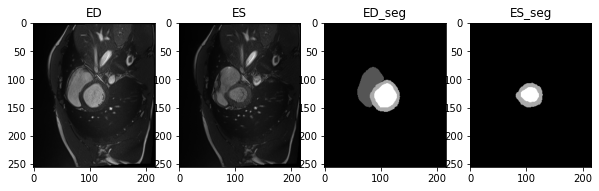

	ID:063, height: 165.0cm, weight: 49.0kg


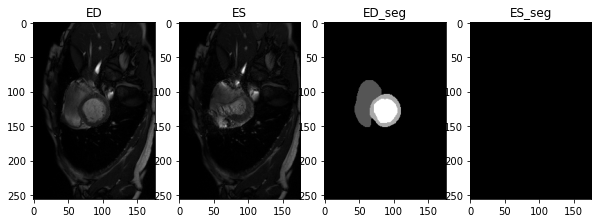

	ID:064, height: 175.0cm, weight: 97.0kg


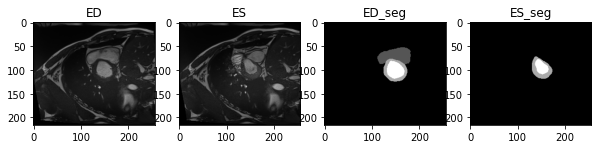

Label: Myocardial infarction

	ID:042, height: 168.0cm, weight: 99.0kg


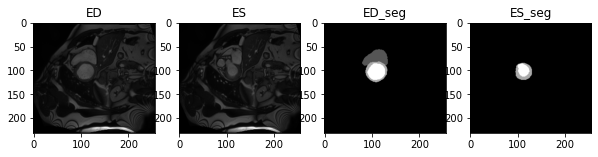

	ID:043, height: 165.0cm, weight: 76.0kg


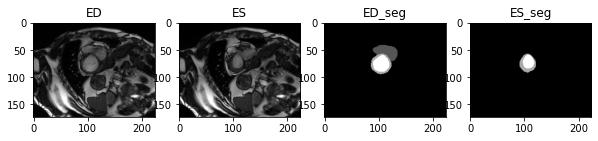

	ID:044, height: 180.0cm, weight: 54.0kg


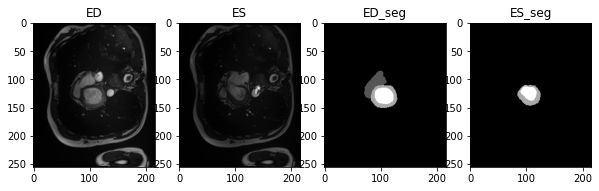

Label: Dilated cardiomyopathy

	ID:002, height: 160.0cm, weight: 70.0kg


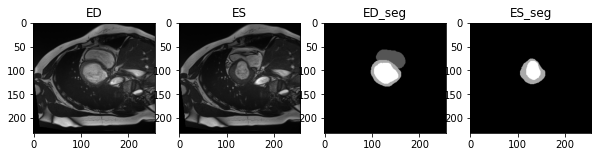

	ID:003, height: 165.0cm, weight: 77.0kg


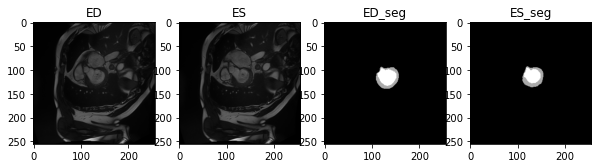

	ID:004, height: 159.0cm, weight: 46.0kg


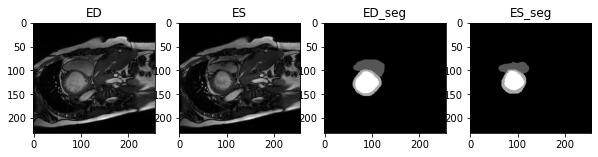

Label: Hypertrophic cardiomyopathy

	ID:022, height: 165.0cm, weight: 42.0kg


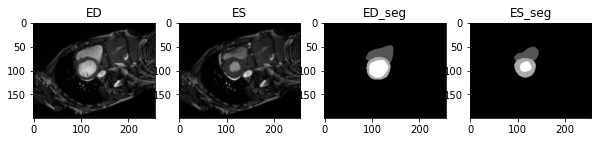

	ID:023, height: 166.0cm, weight: 74.0kg


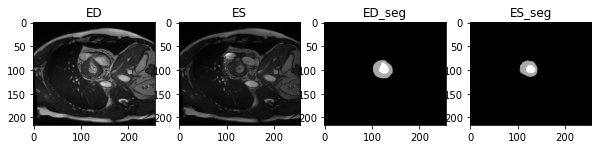

	ID:024, height: 175.0cm, weight: 85.0kg


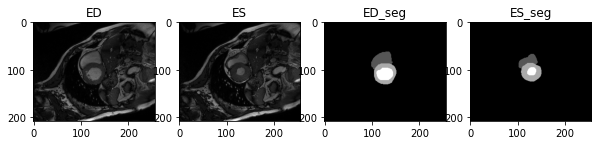

Label: Abnormal right ventricle

	ID:001, height: 184.0cm, weight: 95.0kg


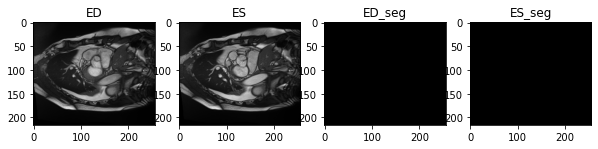

	ID:082, height: 183.0cm, weight: 82.0kg


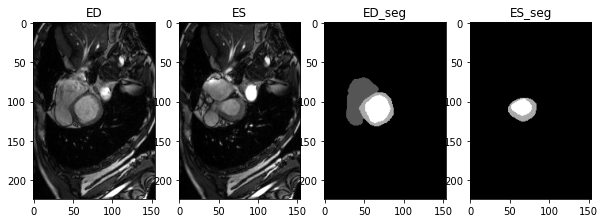

	ID:083, height: 160.0cm, weight: 58.0kg


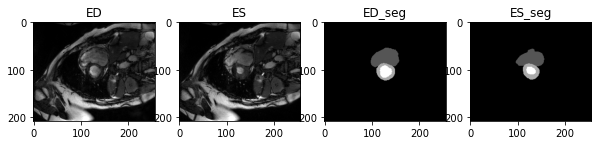

In [7]:
#Display exemples for all classes
for label in class_map.keys():
    display_examples_for_label_train(label)

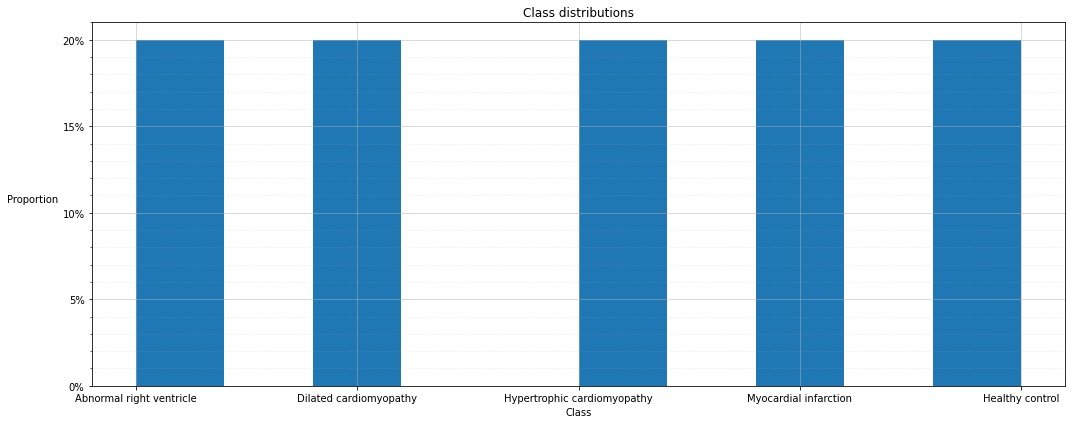

In [8]:
#Looking for class proportions in order to better chose later our classification method
class_labels = [class_map[v["class"]] for v in data.values()]

fig,ax=plt.subplots(figsize=(15,6))

major_ticks_y=np.linspace(0,1,21)
minor_ticks_y=np.linspace(0,1,101)

ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y,minor=True)
ax.set_title("Class distributions")
ax.grid(which="major",alpha=0.6)
ax.grid(which="minor",alpha=0.3,linestyle=':')
ax.hist(class_labels, weights=np.ones(len(class_labels)) / len(class_labels))
ax.set_xlabel('Class')
ax.set_ylabel('Proportion', rotation=0, ha='right')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
# Format x-axis tick labels as integers
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Set maximum number of ticks to 5
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

**NOTE:**
    
We have a perfectly balanced distribution (that might not represent the real world distribution). That will avoid bias that could appear when a class is too represented in train set, such that classing all subject in the dominant class.

### III. Preprocessing

Here we extracted all the data into a dict `data`, composed by 4 3D images for each subject, their height and weight, and the corresponding class.  
The problems now are that:
* we have an enormous amount of features per suject (height, weight, and 4 3D images)
* all subject images do not have the same dimension, so not the same number of feature per subject

#### III.A Standardize our data

In [9]:
# Define the new shape
min_height = np.inf
min_width = np.inf
min_depth = np.inf
for subject_data in data.values():
    for image_data in subject_data['image_data'].values():
        # Flip the image if necessary
        if image_data.shape[0] < image_data.shape[1]:
            image_data = np.transpose(image_data, [1, 0, 2])
        if image_data.shape[1] < image_data.shape[2]:
            image_data = np.transpose(image_data, [0, 2, 1])
        # Update the minimum shape
        min_height = min(min_height, image_data.shape[0])
        min_width = min(min_width, image_data.shape[1])
        min_depth = min(min_depth, image_data.shape[2])

# Create the new feature 'image_resized' for each subject
data_resized = {}
for subject_id, subject_data in data.items():
    subject_images = subject_data['image_data']
    resized_images = {}
    for image_name, image_data in subject_images.items():
        # Flip the image if necessary
        if image_data.shape[0] < image_data.shape[1]:
            image_data = np.transpose(image_data, [1, 0, 2])
        if image_data.shape[1] < image_data.shape[2]:
            image_data = np.transpose(image_data, [0, 2, 1])
        # Resize the image to the minimum shape
        resized_image = np.zeros((min_height, min_width, min_depth))
        resized_image[:image_data.shape[0], :image_data.shape[1], :image_data.shape[2]] = image_data[:min_height, :min_width, :min_depth]
        resized_images[image_name] = resized_image
    data_resized[subject_id] = {"image_data": resized_images, "height": subject_data["height"], "weight": subject_data["weight"], "class": subject_data["class"]}

In [10]:
#Verify that all images are at same dimension
shape = data_resized[1]['image_data']['ED'].shape
for id_, subject in data_resized.items():
    for im in ['ED', 'ES']:
        for suffixe in ['', '_seg']:
            assert subject['image_data'][f'{im}{suffixe}'].shape == shape, f'ID:{id_}, im:{im}{suffixe} has shape {subject["image_data"][f"{im}{suffixe}"].shape}'
print(f'All images have shape {shape}, size {np.prod(shape)}.')


All images have shape (208, 154, 6), size 192192.


In [11]:
# Extract the class, height, weight, and image data from X_resized
y = np.array([subject['class'] for subject in data_resized.values()])
heights = np.array([subject['height'] for subject in data_resized.values()])
weights = np.array([subject['weight'] for subject in data_resized.values()])
images_stacked = np.array([np.concatenate([subject['image_data'][im].reshape(-1) for im in ['ED', 'ES', 'ED_seg', 'ES_seg']]) for subject in data_resized.values()])

In [12]:
X_flat = np.concatenate((np.expand_dims(heights, axis=0).T, np.expand_dims(weights, axis=0).T, images_stacked), axis=1)
print(X_flat.shape)

(100, 768770)


In [13]:
# standardize the data
t0 = time()
scaler = StandardScaler()
X_std = scaler.fit_transform(X_flat)
print(f"Standardization done in {format_duration(time()-t0)}.")

Standardization done in 1.36s.


**NOTES:**
We finally have a set that contains 100 elements (subjects) with the same number of features for each subject (768770). Let's reduce it !

#### III.B Dimensionality reduction - PCA
Let's try to see where the variability of the categories resides.

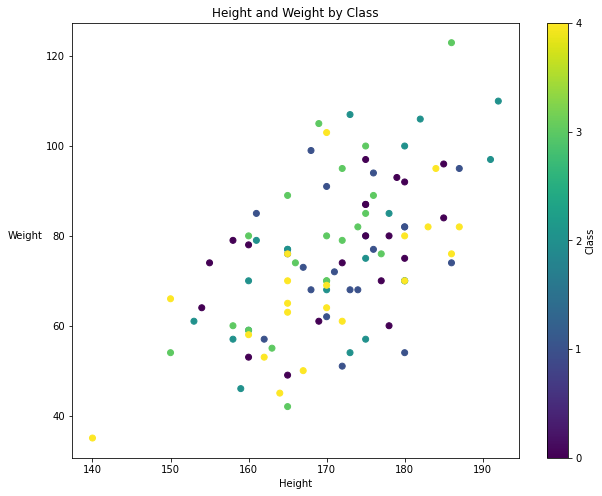

In [14]:
# Plot the data if we only look the height and weight, because that might be an indicator of cardiac health
plt.figure(figsize=(10, 8))
plt.scatter(heights, weights, c=y, cmap='viridis')
plt.colorbar(ticks=range(len(class_map)), label='Class')
plt.xlabel('Height')
plt.ylabel('Weight', rotation=0, ha='right')
plt.title('Height and Weight by Class')
plt.show()

**NOTE:**

Unfortunately, only considering weight and height does not allows us to tell anything about the category of the subject since all distributions overlap. We will need to select features from images, and maybe for that we can use a PCA.

In [15]:
# apply PCA to reduce the dimensionality
t0=time()
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_std)
print(f"PCA done in {format_duration(time()-t0)}. {pca.n_components_} features kept.")

PCA done in 10.23s. 68 features kept.


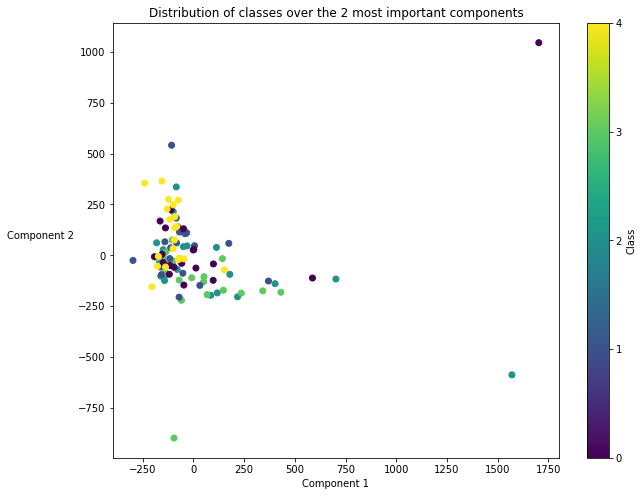

In [16]:
#Plot the data over the 2 most importants features kept
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.colorbar(ticks=range(len(class_map)), label='Class')
plt.xlabel('Component 1')
plt.ylabel('Component 2', rotation=0, ha='right')
plt.title('Distribution of classes over the 2 most important components')
plt.show()

**NOTE:**  
That does not seems to tell us a lot. Let's moving to the last preprocessing phase: separate our data between train set and validation set.

#### III.C Create train set and validation set  
Here in our project we have:
- a train set
- a test set  

The problem is that we do not have access to the classes of the test set, and we do not want to overfit the model to that set. So we will separate the "train" set into an actual train set and a validation set, the second one will be the one that will be used to evaluate the performances of our models, and then make the choice of the best model.

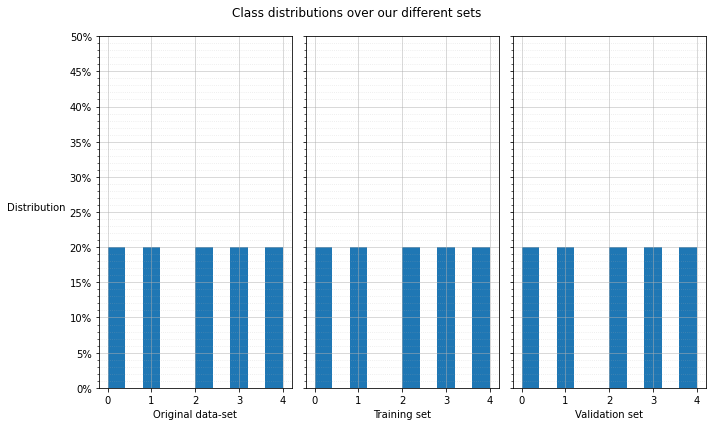

In [17]:
# Create training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,6))

fig.suptitle('Class distributions over our different sets')
axs[0].hist(y,weights=np.ones_like(y)/len(y))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_val,weights=np.ones_like(y_val)/len(y_val))
axs[2].set_xlabel('Validation set')
axs[0].set_ylabel('Distribution', rotation=0, ha='right')

major_ticks_y=np.linspace(0,.5,11)
minor_ticks_y=np.linspace(0,.5,51)
for i in range(3):
    axs[i].set_yticks(major_ticks_y)
    axs[i].set_yticks(minor_ticks_y,minor=True)
    axs[i].grid(which="major",alpha=0.6)
    axs[i].grid(which="minor",alpha=0.3,linestyle=':')
    axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    plt.tight_layout()
plt.show()

### IV. Supervised ML
#### IV.A Usual methods

Fitting LDA to training set
LDA : done in 12.49ms.
              precision    recall  f1-score   support

         0.0       0.20      0.25      0.22         4
         1.0       0.00      0.00      0.00         4
         2.0       0.50      0.25      0.33         4
         3.0       0.20      0.25      0.22         4
         4.0       0.60      0.75      0.67         4

    accuracy                           0.30        20
   macro avg       0.30      0.30      0.29        20
weighted avg       0.30      0.30      0.29        20

Categorization Accuracy : 30.00%


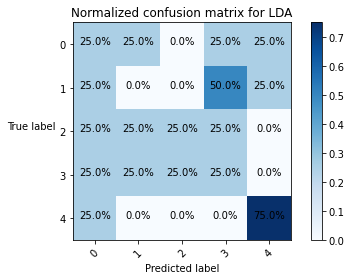

Fitting QDA to training set
QDA : done in 11.99ms.
              precision    recall  f1-score   support

         0.0       0.40      0.50      0.44         4
         1.0       0.17      0.25      0.20         4
         2.0       0.33      0.25      0.29         4
         3.0       0.00      0.00      0.00         4
         4.0       0.25      0.25      0.25         4

    accuracy                           0.25        20
   macro avg       0.23      0.25      0.24        20
weighted avg       0.23      0.25      0.24        20

Categorization Accuracy : 25.00%


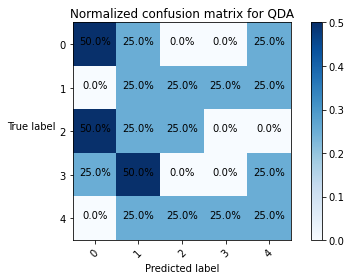

Fitting Perceptron to training set
Perceptron : done in 15.43ms.
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         4
         2.0       1.00      0.25      0.40         4
         3.0       0.40      0.50      0.44         4
         4.0       0.60      0.75      0.67         4

    accuracy                           0.45        20
   macro avg       0.52      0.45      0.44        20
weighted avg       0.52      0.45      0.44        20

Categorization Accuracy : 45.00%


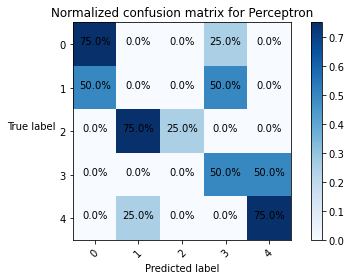

Fitting LSVM to training set
LSVM : done in 37.57ms.
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.00      0.00      0.00         4
         2.0       1.00      0.25      0.40         4
         3.0       0.50      0.50      0.50         4
         4.0       0.67      1.00      0.80         4

    accuracy                           0.50        20
   macro avg       0.58      0.50      0.49        20
weighted avg       0.58      0.50      0.49        20

Categorization Accuracy : 50.00%


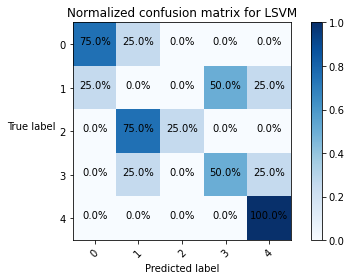

Fitting SVM to training set
SVM : done in 8.89ms.
              precision    recall  f1-score   support

         0.0       0.50      0.25      0.33         4
         1.0       0.25      0.50      0.33         4
         2.0       0.50      0.75      0.60         4
         3.0       0.00      0.00      0.00         4
         4.0       1.00      0.75      0.86         4

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.42        20
weighted avg       0.45      0.45      0.42        20

Categorization Accuracy : 45.00%


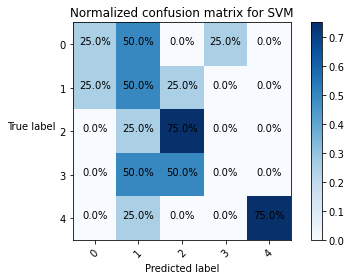

In [18]:
# Fitting some usual methods seen during the IMA205 courses
methods = {"LDA": LinearDiscriminantAnalysis(), "QDA": QuadraticDiscriminantAnalysis(), 'Perceptron':Perceptron(), 'LSVM':LinearSVC(), 'SVM':SVC()}
for name, method in methods.items():
    print(f"Fitting {name} to training set")
    t0 = time()
    method.fit(X_train, y_train)
    y_pred = method.predict(X_val)
    print(f"{name} : done in {format_duration(time()-t0)}.")

    print(classification_report(y_val, y_pred))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_val, y_pred)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_map.keys(), normalize=True,
                          title=f'Normalized confusion matrix for {name}')
    plt.show()

**NOTE:**  
We have some methods that gives us somme relatively goods results, knowing that we have 5 classes, a random classifier would have an accuracy arround $20\%$.  
The Perceptron and the SVMs are the best ones, with accuracies between $45\%$ and $50\%$.

#### IV.B Cross-Validation
The results we obtain are based on a precise subdivision of the data into training and validation sets. This can thus bias the results. Therefore, we will use `Cross-validation`.

Running cross validation for LDA...
LDA : done in 18.09ms.
LDA score: mean=29.0%, std=9.7%.

Running cross validation for QDA...
QDA : done in 11.92ms.
QDA score: mean=20.0%, std=5.5%.

Running cross validation for Perceptron...
Perceptron : done in 15.41ms.
Perceptron score: mean=26.0%, std=9.2%.

Running cross validation for LSVM...
Grid search for LSVM...
Best training params for LSVM: {'C': 0.005}
LSVM : done in 2.63s.
LSVM score: mean=39.0%, std=9.7%.

Running cross validation for SVM...
Grid search for SVM...
Best training params for SVM: {'C': 0.0001, 'gamma': 0.001}
SVM : done in 397.04ms.
SVM score: mean=33.0%, std=11.2%.



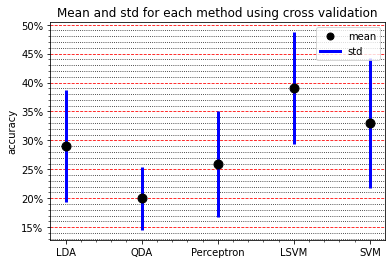

In [19]:
# Cross-validation for Model Assessment

scores = {}
methods = {'LDA': LinearDiscriminantAnalysis(), 'QDA':QuadraticDiscriminantAnalysis(),
            'Perceptron':Perceptron(), 'LSVM':LinearSVC(), 'SVM':SVC()}

# Define the hyperparameter distribution for each method
params = {
    'LSVM': {'C': [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,7,8,9,1e1],},
    'SVM': {'C': [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,1,2,3,4,5,6,7,8,9,1e1], 
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
}

# Run randomized search for each method
for name, method in methods.items():
    print(f"Running cross validation for {name}...")
    t0 = time()
    if name == 'LSVM' or name == 'SVM':
        print(f'Grid search for {name}...')
        grid_search = GridSearchCV(method, params[name], cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X_pca, y)
        print(f"Best training params for {name}: {grid_search.best_params_}")
        if name == "SVM":
            method = SVC(**grid_search.best_params_)
        elif name == "LSVM":
            method = LinearSVC(**grid_search.best_params_)
    method_scores = cross_val_score(method, X_pca, y, cv=5, scoring="accuracy")
    print(f"{name} : done in {format_duration(time()-t0)}.")
    scores[name] = {'scores': method_scores, 'mean': method_scores.mean(), 'std': method_scores.std()}
    print(f"{name} score: mean={scores[name]['mean']:.1%}, std={scores[name]['std']:.1%}.\n")

# Create a boxplot of the data
plt.figure()
means = [scores[name]['mean'] for name in methods.keys()]
stds = [scores[name]['std'] for name in methods.keys()]
plt.errorbar(methods.keys(), means, stds, fmt='ok', ms=9, lw=3, ecolor='b')

plt.ylabel('accuracy')

# Legend
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', lw=0, ms=7, label='mean'),
                   Line2D([0], [0], color='b', lw=3, label='std'),]

plt.legend(handles=legend_elements)

plt.title("Mean and std for each method using cross validation")

# Show the grid and plot
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])
plt.show()

**NOTE:**  
It appears that we have a high std for every method, and results that are not such as good as we could think using our set separation.

### V. Unsupervised ML - Neural Networks

Training
Epoch 1/20
2/2 [==============================] - 1s 12ms/step - loss: 2.2584 - accuracy: 0.2750
Epoch 2/20
2/2 [==============================] - 0s 5ms/step - loss: 0.5096 - accuracy: 0.8375
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4099 - accuracy: 0.8875
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.3648 - accuracy: 0.9000
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.2154 - accuracy: 0.9625
Epoch 6/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1531 - accuracy: 0.9625
Epoch 7/20
2/2 [==============================] - 0s 7ms/step - loss: 0.1345 - accuracy: 0.9375
Epoch 8/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 1.0000
Epoch 9/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.9875
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0610 - accuracy: 0.9875
Epoch 11/20
2/2 [============

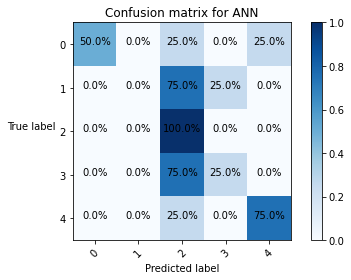

In [20]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons

# One-hot encode the target variable
y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_val)

n_input = X_train.shape[1]
n_classes = y_train_enc.shape[1]

model_mlp_multi_layer = Sequential()
model_mlp_multi_layer.add(Dense(n_hidden_1, input_dim=n_input, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_classes, activation="sigmoid"))

# create the loss and optimiser, use 'categorical_crossentropy' in loss
model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 20
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_train, y_train_enc, epochs=n_epochs, batch_size=batch_size)

print('Testing')
model_mlp_multi_layer.evaluate(X_val, y_val_enc, verbose=2)

y_pred = model_mlp_multi_layer.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_classes))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_map.keys(), normalize=True,
                      title='Confusion matrix for ANN')
plt.show()

**NOTE:**  
The model is clearly overfitting, maybe because of the high number of neurons, or simply because the `PCA`. Let's try to find for the best number of neurons.

In [21]:
y_enc = to_categorical(y)

# define the function to create the model
def create_model(n_hidden_1=64, n_hidden_2=32, n_hidden_3=16):
    model_mlp_multi_layer = Sequential()
    model_mlp_multi_layer.add(Dense(n_hidden_1, input_dim=n_input, activation="relu"))
    model_mlp_multi_layer.add(BatchNormalization())
    model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
    model_mlp_multi_layer.add(BatchNormalization())
    model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
    model_mlp_multi_layer.add(BatchNormalization())
    model_mlp_multi_layer.add(Dense(n_classes, activation="sigmoid"))
    model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_mlp_multi_layer

# create the Keras model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
param_grid = {'n_hidden_1': [32, 64, 128],
              'n_hidden_2': [16, 32, 64],
              'n_hidden_3': [8, 16, 32]}

# perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_pca, y_enc)

# print the best parameters and score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

Best parameters:  {'n_hidden_1': 32, 'n_hidden_2': 32, 'n_hidden_3': 8}
Best score:  0.4900000013411045


Training
Epoch 1/20
2/2 [==============================] - 1s 4ms/step - loss: 2.0940 - accuracy: 0.2375
Epoch 2/20
2/2 [==============================] - 0s 0s/step - loss: 1.2433 - accuracy: 0.5375
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 0.6875
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.8373 - accuracy: 0.8000
Epoch 5/20
2/2 [==============================] - 0s 6ms/step - loss: 0.7481 - accuracy: 0.8625
Epoch 6/20
2/2 [==============================] - 0s 6ms/step - loss: 0.6485 - accuracy: 0.8625
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.5116 - accuracy: 0.9250
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5033 - accuracy: 0.9125
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4015 - accuracy: 0.9500
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3441 - accuracy: 0.9000
Epoch 11/20
2/2 [==============

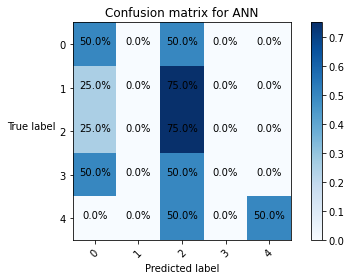

In [22]:
# Network Parameters
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 16 # 2nd layer number of neurons
n_hidden_3 = 32 # 3rd layer number of neurons

# One-hot encode the target variable
y_train_enc = to_categorical(y_train)
y_val_enc = to_categorical(y_val)

n_input = X_train.shape[1]
n_classes = y_train_enc.shape[1]

model_mlp_multi_layer = Sequential()
model_mlp_multi_layer.add(Dense(n_hidden_1, input_dim=n_input, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_classes, activation="sigmoid"))

# create the loss and optimiser, use 'categorical_crossentropy' in loss
model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 20
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_train, y_train_enc, epochs=n_epochs, batch_size=batch_size)

print('Testing')
model_mlp_multi_layer.evaluate(X_val, y_val_enc, verbose=2)

y_pred = model_mlp_multi_layer.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_classes))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred_classes)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_map.keys(), normalize=True,
                      title='Confusion matrix for ANN')
plt.show()

**NOTE:**  
The neural network with the providen feature is not able to give a better result. We might finally want to try extract meaningfull features such as seen in some documentation.

### VI. Predict over the test set

In [23]:
test_folder = "Test/"

#TEST SET
data_test = {}

# extract metadata
metadata = np.loadtxt(f"metadataTest.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights = metadata[:, 1]
weights = metadata[:, 2]

for i, id_subject in enumerate(ids):
    # Get the image data and metadata for the current subject
    image_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(test_folder, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            image_data[f"{image_type}{image_suffix}"] = nib.load(image_path).get_fdata()
    data_test[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights[i], "weight": weights[i]}


In [24]:
# Define the new shape
min_height = np.inf
min_width = np.inf
min_depth = np.inf
for subject_data in data_test.values():
    for image_data in subject_data['image_data'].values():
        # Flip the image if necessary
        if image_data.shape[0] < image_data.shape[1]:
            image_data = np.transpose(image_data, [1, 0, 2])
        if image_data.shape[1] < image_data.shape[2]:
            image_data = np.transpose(image_data, [0, 2, 1])
        # Update the minimum shape
        min_height = min(min_height, image_data.shape[0])
        min_width = min(min_width, image_data.shape[1])
        min_depth = min(min_depth, image_data.shape[2])

# Create the new feature 'image_resized' for each subject
data_test_resized = {}
for subject_id, subject_data in data_test.items():
    subject_images = subject_data['image_data']
    resized_images = {}
    for image_name, image_data in subject_images.items():
        # Flip the image if necessary
        if image_data.shape[0] < image_data.shape[1]:
            image_data = np.transpose(image_data, [1, 0, 2])
        if image_data.shape[1] < image_data.shape[2]:
            image_data = np.transpose(image_data, [0, 2, 1])
        # Resize the image to the minimum shape
        resized_image = np.zeros((min_height, min_width, min_depth))
        resized_image[:image_data.shape[0], :image_data.shape[1], :image_data.shape[2]] = image_data[:min_height, :min_width, :min_depth]
        resized_images[image_name] = resized_image
    data_test_resized[subject_id] = {"image_data": resized_images, "height": subject_data["height"], "weight": subject_data["weight"]}

In [25]:
#Verify that all images are at same dimension
shape = data_test_resized[101]['image_data']['ED'].shape
for id_, subject in data_test_resized.items():
    for im in ['ED', 'ES']:
        for suffixe in ['', '_seg']:
            assert subject['image_data'][f'{im}{suffixe}'].shape == shape, f'ID:{id_}, im:{im}{suffixe} has shape {subject["image_data"][f"{im}{suffixe}"].shape}'
print(f'All images have shape {shape}, size {np.prod(shape)}.')

All images have shape (208, 154, 6), size 192192.


In [26]:
# Extract the height, weight, and image data from data__test_resized
heights_test = np.array([subject['height'] for subject in data_test_resized.values()])
weights_test = np.array([subject['weight'] for subject in data_test_resized.values()])
images_stacked_test = np.array([np.concatenate([subject['image_data'][im].reshape(-1) for im in ['ED', 'ES', 'ED_seg', 'ES_seg']]) for subject in data_test_resized.values()])

In [27]:
X_test_flat = np.concatenate((np.expand_dims(heights_test, axis=0).T, np.expand_dims(weights_test, axis=0).T, images_stacked_test), axis=1)
print(X_test_flat.shape)

(50, 768770)


In [28]:
t0=time()
X_test_std = scaler.fit_transform(X_test_flat)
print(f"Standardization done in {format_duration(time()-t0)}.")

Standardization done in 859.74ms.


In [29]:
# apply PCA to reduce the dimensionality
t0=time()
X_test_pca = pca.transform(X_test_std)
print(f"PCA done in {format_duration(time()-t0)}. {pca.n_components_} features kept.")

PCA done in 1.03s. 68 features kept.


In [30]:
# Network Parameters
n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 16 # 2nd layer number of neurons
n_hidden_3 = 32 # 3rd layer number of neurons

# One-hot encode the target variable
y_enc = to_categorical(y)

n_input = X_train.shape[1]
n_classes = y_enc.shape[1]

model_mlp_multi_layer = Sequential()
model_mlp_multi_layer.add(Dense(n_hidden_1, input_dim=n_input, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_2, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_hidden_3, activation="relu"))
model_mlp_multi_layer.add(BatchNormalization())
model_mlp_multi_layer.add(Dense(n_classes, activation="sigmoid"))

# create the loss and optimiser, use 'categorical_crossentropy' in loss
model_mlp_multi_layer.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.01), metrics=["accuracy"])

# Run optimisation algorithm
n_epochs = 20
batch_size = 64

print('Training')
model_mlp_multi_layer.fit(X_pca, y_enc, epochs=n_epochs, batch_size=batch_size)

y_pred = model_mlp_multi_layer.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)

Training
Epoch 1/20
2/2 [==============================] - 1s 8ms/step - loss: 2.0255 - accuracy: 0.1400
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 1.3298 - accuracy: 0.4300
Epoch 3/20
2/2 [==============================] - 0s 4ms/step - loss: 1.1078 - accuracy: 0.5600
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.9508 - accuracy: 0.7100
Epoch 5/20
2/2 [==============================] - 0s 5ms/step - loss: 0.8499 - accuracy: 0.7300
Epoch 6/20
2/2 [==============================] - 0s 4ms/step - loss: 0.7282 - accuracy: 0.8200
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.8700
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.5502 - accuracy: 0.8900
Epoch 9/20
2/2 [==============================] - 0s 3ms/step - loss: 0.4560 - accuracy: 0.9100
Epoch 10/20
2/2 [==============================] - 0s 4ms/step - loss: 0.3778 - accuracy: 0.9000
Epoch 11/20
2/2 [=============

In [31]:
y_pred_classes

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 4, 2, 2, 2, 3, 2, 0, 2, 3, 2, 2, 4, 2,
       3, 2, 0, 2, 2, 2, 4, 2, 2, 4, 2, 0, 2, 3, 0, 2, 2, 4, 3, 2, 3, 1,
       0, 2, 3, 3, 3, 2], dtype=int64)

In [32]:
'''
df = pd.DataFrame({"Id": range(101, 151), "Category": y_pred_classes})

# Write the dataframe to a CSV file
df.to_csv("Predictions.csv", index=False)'''

'\ndf = pd.DataFrame({"Id": range(101, 151), "Category": y_pred_classes})\n\n# Write the dataframe to a CSV file\ndf.to_csv("Predictions.csv", index=False)'

### VI. Changing our features
Using the models with raw data, we obtain poor results. That can be because:
- using `pca` when having a lot more of data than sample can lead to overfitting
- the test set is actually different than the train data, because for example it does not have any `LVC` segmentation, and the models might used it  
In this part, we will try to use more coherent features with our problem, stocking with propositions of the articles.

In [33]:
# Let's reimport properly our data, adding the zoom parameter to the images (for better normalization)
train_folder = "Train"
test_folder = "Test"

# Define the mapping from class labels to diagnostic classes
class_map = {
    0: "Healthy control",
    1: "Myocardial infarction",
    2: "Dilated cardiomyopathy",
    3: "Hypertrophic cardiomyopathy",
    4: "Abnormal right ventricle"
}


# Data used for training
print("Importing data for training...")
t0=time()
data = {}

# extract metadata
metadata = np.loadtxt(f"metadataTrain.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights = metadata[:, 2]
weights = metadata[:, 3]

for i in tqdm(range(len(ids))):
    id_subject = ids[i]
    # Get the image data and metadata for the current subject
    image_data = {}
    zoom_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(train_folder, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            im = nib.load(image_path)
            image_data[f"{image_type}{image_suffix}"] = im.get_fdata()
            zoom_data[f"{image_type}{image_suffix}"] = im.header.get_zooms()[:-1]
    data[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "zoom_data": {k: v for k, v in zoom_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights[i], "weight": weights[i], 
                        "class": metadata[i-1, 1]}
print(f"Data for training imported. {len(data)} elements founds. Done in {format_duration(time()-t0)}.\n")

# Data for the predictions
print("Importing data for predictions...")
t0=time()
data_test = {}

# extract metadata
metadata = np.loadtxt(f"metadataTest.csv", delimiter=",", skiprows=1)
ids = metadata[:, 0].astype(int)
heights = metadata[:, 1]
weights = metadata[:, 2]

for i in tqdm(range(len(ids))):
    id_subject = ids[i]
    # Get the image data and metadata for the current subject
    image_data = {}
    zoom_data = {}
    for image_type in ['ED', 'ES']:
        for image_suffix in ['', '_seg']:
            image_path = os.path.join(test_folder, f"{id_subject:03}/{id_subject:03}_{image_type}{image_suffix}.nii")
            im = nib.load(image_path)
            image_data[f"{image_type}{image_suffix}"] = im.get_fdata()
            zoom_data[f"{image_type}{image_suffix}"] = im.header.get_zooms()[:-1]
    data_test[id_subject] = {"image_data": {k: v for k, v in image_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "zoom_data": {k: v for k, v in zoom_data.items() if k in ['ED', 'ES', 'ED_seg', 'ES_seg']},
                        "height": heights[i], "weight": weights[i]}
print(f"Data for predictions imported. {len(data_test)} elements founds. Done in {format_duration(time()-t0)}.\n")

Importing data for training...


  0%|          | 0/100 [00:00<?, ?it/s]

Data for training imported. 100 elements founds. Done in 3.14s.

Importing data for predictions...


  0%|          | 0/50 [00:00<?, ?it/s]

Data for predictions imported. 50 elements founds. Done in 2.45s.



#### VI.A Segment `LVC` in test data
We first need to segment the test set images because they are partially segmented for now.  
Knowing that the left ventricle cavity lies inside the left ventricle myocardium, we wille try to segment the cavity by growing a region starting from a point that should be inside the myocardium: the centroid of the myocardium.
We will try do apply that with the train dataset in which we hide the `LVC` segmentation in order to validate if we correctly recreate the segmentation.

In [34]:
def find_nearest_zero_label(centroid, seg):
    # Find all the points with label 0
    zero_points = np.argwhere(seg == 0)
    if len(zero_points) == 0:
        return None
    
    # Calculate the Euclidean distance between each point and the centroid
    distances = cdist([centroid], zero_points, 'euclidean').flatten()
    
    # Find the point with the minimum distance
    min_idx = np.argmin(distances)
    nearest_point = zero_points[min_idx]
    
    return nearest_point

def get_label_extrema(seg, label):
    indices = np.argwhere(seg == label)
    if len(indices) == 0:
        return None
    x_min, y_min = np.min(indices, axis=0)
    x_max, y_max = np.max(indices, axis=0)
    return x_min+1, x_max-1, y_min+1, y_max-1

def extract_region(target_label, labels_kept, centroid_label, partial_seg, gt_seg=None):
    if np.sum(partial_seg==centroid_label) == 0:
        if gt_seg is not None:
            return ((partial_seg, 1), "NO_DATA")
        return ((partial_seg,), "NO_DATA")
    #restricting the search of LVC to the area of the myocardium
    xmin, xmax, ymin, ymax = get_label_extrema(partial_seg, centroid_label)
    cropped_seg = partial_seg[xmin:xmax, ymin:ymax]
    
    #predicting one possible point inside the LVC
    starting_point = np.round(np.mean(np.where(partial_seg==centroid_label), axis=1)).astype(int)
    warning=False
    if partial_seg[starting_point[0], starting_point[1]] == centroid_label:
        warning=True
        starting_point = find_nearest_zero_label(starting_point, partial_seg)
        if xmax <= starting_point[0] or starting_point[0] <= xmin or ymax <= starting_point[1] or starting_point[1] <= ymin:
            #abort, we cannot find an interior point with null label, this data might tell something
            if gt_seg is not None:
                return ((partial_seg, 1,), "ABORTED")
            return ((partial_seg,), "ABORTED")
    # grow new label from the possible point
    full_seg = deepcopy(partial_seg)
    full_seg[xmin:xmax, ymin:ymax] = flood_fill(cropped_seg, (starting_point[0]-xmin, starting_point[1]-ymin), target_label, connectivity=1)
    # compute IoU if ground truth is given
    if gt_seg is not None:
        iou = np.sum(np.logical_and(full_seg==target_label, gt_seg==target_label)) / np.sum(np.logical_or(full_seg==target_label, gt_seg==target_label))
        return ((full_seg, iou,), "WARNING" if warning else "OK")
    else:
        return ((full_seg,), "WARNING" if warning else "OK")
    

  0%|          | 0/100 [00:00<?, ?it/s]

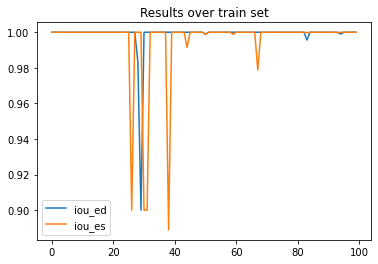

Results over train dataset:
ED:	mean:99.9%
	std:1.0%
	
ES:	mean:99.6%
	std:2.0%


In [35]:
full_seg_ed_train = [subject["image_data"]['ED_seg'] for subject in data.values()]
full_seg_es_train = [subject["image_data"]['ES_seg'] for subject in data.values()]
partial_seg_ed_train = [seg%3 for seg in full_seg_ed_train]
partial_seg_es_train = [seg%3 for seg in full_seg_es_train]

predict_full_seg_es_train = deepcopy(partial_seg_es_train)
predict_full_seg_ed_train = deepcopy(partial_seg_ed_train)
ious_ed = np.zeros(len(predict_full_seg_ed_train))
ious_es = np.zeros(len(predict_full_seg_es_train))
statuses_ed = np.zeros((len(predict_full_seg_ed_train), 4))
statuses_es = np.zeros((len(predict_full_seg_es_train), 4))

for i in tqdm(range(len(predict_full_seg_ed_train))):
    tmp_iou_ed = np.zeros(predict_full_seg_ed_train[i].shape[-1])
    tmp_iou_es = np.zeros(predict_full_seg_es_train[i].shape[-1])
    dict_statuses_ed = {"OK": 0, "NO_DATA":0, "WARNING": 0, "ABORTED": 0}
    dict_statuses_es = {"OK": 0, "NO_DATA":0, "WARNING": 0, "ABORTED": 0}
    for p in range(predict_full_seg_ed_train[i].shape[-1]):
        (predict_full_seg_ed_train[i][:,:,p], iou_ed), status_ed = extract_region(3, [1, 2], 2, partial_seg_ed_train[i][:,:,p], full_seg_ed_train[i][:,:,p])
        (predict_full_seg_es_train[i][:,:,p], iou_es), status_es = extract_region(3, [1, 2], 2, partial_seg_es_train[i][:,:,p], full_seg_es_train[i][:,:,p])
        tmp_iou_ed[p] += iou_ed
        tmp_iou_es[p] += iou_es
        dict_statuses_ed[status_ed] += 1
        dict_statuses_es[status_es] += 1
        '''
        if status_ed in ["NO_DATA", "ABORTED", "WARNING"] or status_es in ["NO_DATA", "ABORTED", "WARNING"]:
            fig, axs = plt.subplots(1, 6)
            fig.set_size_inches(15, 15)
            print(f"i={i}, p={p}, statuses=({status_ed}, {status_es}), ious=({tmp_iou_ed[p]:.2%}, {tmp_iou_es[p]:.2%})")
            axs[0].imshow(partial_seg_ed_train[i][:,:,p])
            axs[0].set_title("partial_ed")
            axs[1].imshow(predict_full_seg_ed_train[i][:,:,p])
            axs[1].set_title("predict_ed")
            axs[2].imshow(full_seg_ed_train[i][:,:,p])
            axs[2].set_title("truth_ed")
            axs[3].imshow(partial_seg_es_train[i][:,:,p])
            axs[3].set_title("partial_es")
            axs[4].imshow(predict_full_seg_es_train[i][:,:,p])
            axs[4].set_title("predict_es")
            axs[5].imshow(full_seg_es_train[i][:,:,p])
            axs[5].set_title("truth_es")
            plt.show()'''
    ious_ed[i] = np.mean(tmp_iou_ed)
    ious_es[i] = np.mean(tmp_iou_es)
    #Maybe the info that we had some issue to recover the LVC can be used later
    statuses_ed[i] = dict_statuses_ed["OK"], dict_statuses_ed["NO_DATA"], dict_statuses_ed["WARNING"], dict_statuses_ed["ABORTED"]
    statuses_ed[i] /= statuses_ed[i].sum()
    statuses_es[i] = dict_statuses_es["OK"], dict_statuses_es["NO_DATA"], dict_statuses_es["WARNING"], dict_statuses_es["ABORTED"]
    statuses_es[i] /= statuses_es[i].sum()
ious_ed = np.array(ious_ed)
ious_es = np.array(ious_es)
plt.plot(ious_ed, label = 'iou_ed')
plt.plot(ious_es, label = 'iou_es')
plt.title('Results over train set')
plt.legend()
plt.show()
print(f"Results over train dataset:\nED:\tmean:{np.mean(ious_ed):.1%}\n\tstd:{np.std(ious_ed):.1%}\n\t\nES:\tmean:{np.mean(ious_es):.1%}\n\tstd:{np.std(ious_es):.1%}")
    

**NOTE:**
We obtain a very good segmentation algorithm that allow us to retrieve the segmentation of `LVC` for the test data !  
Some cases are difficults, but in that case, as we stock our statuses, maybe they can be used to tell something in the classification.

In [36]:
partial_seg_ed_test = [subject["image_data"]['ED_seg'] for subject in data_test.values()]
partial_seg_es_test = [subject["image_data"]['ES_seg'] for subject in data_test.values()]

predict_full_seg_es_test = deepcopy(partial_seg_es_test)
predict_full_seg_ed_test = deepcopy(partial_seg_ed_test)

statuses_test_ed = np.zeros((len(predict_full_seg_ed_test), 4))
statuses_test_es = np.zeros((len(predict_full_seg_es_test), 4))

for i in tqdm(range(len(predict_full_seg_ed_test))):
    dict_statuses_ed = {"OK": 0, "NO_DATA":0, "WARNING": 0, "ABORTED": 0}
    dict_statuses_es = {"OK": 0, "NO_DATA":0, "WARNING": 0, "ABORTED": 0}
    for p in range(predict_full_seg_ed_test[i].shape[-1]):
        (predict_full_seg_ed_test[i][:,:,p],), status_ed = extract_region(3, [1, 2], 2, partial_seg_ed_test[i][:,:,p])
        (predict_full_seg_es_test[i][:,:,p],), status_es = extract_region(3, [1, 2], 2, partial_seg_es_test[i][:,:,p])
        dict_statuses_ed[status_ed] += 1
        dict_statuses_es[status_es] += 1
        '''
        if status_ed in ["NO_DATA", "ABORTED", "WARNING"] or status_es in ["NO_DATA", "ABORTED", "WARNING"]:
            fig, axs = plt.subplots(1, 4)
            fig.set_size_inches(15, 15)
            print(f"i={i}, p={p}, statuses=({status_ed}, {status_es})")
            axs[0].imshow(partial_seg_ed_test[i][:,:,p])
            axs[0].set_title("partial_ed")
            axs[1].imshow(predict_full_seg_ed_test[i][:,:,p])
            axs[1].set_title("predict_ed")
            axs[2].imshow(partial_seg_es_test[i][:,:,p])
            axs[2].set_title("partial_es")
            axs[3].imshow(predict_full_seg_es_test[i][:,:,p])
            axs[3].set_title("predict_es")
            plt.show()'''
    #Maybe the info that we had some issue to recover the LVC can be used later
    statuses_test_ed[i] = dict_statuses_ed["OK"], dict_statuses_ed["NO_DATA"], dict_statuses_ed["WARNING"], dict_statuses_ed["ABORTED"]
    statuses_test_ed[i] /= statuses_test_ed[i].sum()
    statuses_test_es[i] = dict_statuses_es["OK"], dict_statuses_es["NO_DATA"], dict_statuses_es["WARNING"], dict_statuses_es["ABORTED"]
    statuses_test_es[i] /= statuses_test_es[i].sum()


  0%|          | 0/50 [00:00<?, ?it/s]

#### VI.B Creating features
We are now able to create features mentionned in the article, such as volumes of every segmented parts.

In [37]:
for id_, subject in data.items():
    zoom = subject['zoom_data']['ED']
    for im in ['ES', 'ES_seg', 'ED_seg']:
        assert zoom == subject['zoom_data'][im], f"Different zoom for id:{id}."
print("For every subject in training data, the zoom is unique.")
for id_, subject in data_test.items():
    zoom = subject['zoom_data']['ED']
    for im in ['ES', 'ES_seg', 'ED_seg']:
        assert zoom == subject['zoom_data'][im], f"Different zoom for id:{id}."
print("For every subject in test data, the zoom is unique.")


For every subject in training data, the zoom is unique.
For every subject in test data, the zoom is unique.


In [38]:
# Let's recap all the features we have for now, for the data used to train and the test data
heights_data = np.array([subject['height'] for subject in data.values()])
heights_test = np.array([subject['height'] for subject in data_test.values()])

weights_data = np.array([subject['weight'] for subject in data.values()])
weights_test = np.array([subject['weight'] for subject in data_test.values()])

bmi_data = np.divide(weights_data, heights_data**2)
bmi_test = np.divide(weights_test, heights_test**2)

statuses_seg_LVC_data = np.stack((statuses_ed, statuses_es), axis=1)
statuses_seg_LVC_test = np.stack((statuses_test_ed, statuses_test_es), axis=1)

zooms_data = np.array([subject['zoom_data']['ED'] for subject in data.values()])
zooms_test = np.array([subject['zoom_data']['ED'] for subject in data_test.values()])

y_data = [subject['class'] for subject in data.values()]


In [39]:
# Let's calculate the volumes of RVC, LVM and LVC for each subject
def calc_volume(mask_3D, label, zoom):
    '''
    zoom is given in mm
    label 1 for RVC, 2 for LVM, 3 for LVC
    return the volume in mL
    '''
    s = np.sum(mask_3D==label) #number of voxels of corresponding label
    v = np.prod(zoom) #volume of 1 voxel in mm^3, i.e 1E-3 mL
    return s*v / 1000


In [51]:
volumes_ed_data = np.array([[calc_volume(predict_full_seg_ed_train[i], label, zooms_data[i]) for label in [1, 2, 3]] for i in range(len(data))])
volumes_es_data = np.array([[calc_volume(predict_full_seg_es_train[i], label, zooms_data[i]) for label in [1, 2, 3]] for i in range(len(data))])
volumes_data = np.stack((volumes_ed_data, volumes_es_data), axis=1)
ratio_volumes_data = np.divide(volumes_ed_data, volumes_es_data)

volumes_ed_test = np.array([[calc_volume(predict_full_seg_ed_test[i], label, zooms_test[i]) for label in [1, 2, 3]] for i in range(len(data_test))])
volumes_es_test = np.array([[calc_volume(predict_full_seg_es_test[i], label, zooms_test[i]) for label in [1, 2, 3]] for i in range(len(data_test))])
volumes_test = np.stack((volumes_ed_test, volumes_es_test), axis=1)
ratio_volumes_test = np.divide(volumes_ed_test, volumes_es_test)


In [57]:
def calculate_LVM_LVC_thickness(segmentation):
    """
    Calculate the thickness of LVM between LVC and RVC in a 2D slice.
    :param segmentation: 2D numpy array with values 0 for background, 1 for RVC, 2 for LVM and 3 for LVC
    :return: thickness of LVM between LVC and RVC, or None if the segmentation is not complete
    """
    lvc_mask = (segmentation == 3)
    lvm_mask = (segmentation == 2)
    rvc_mask = (segmentation == 1)
    
    if not (np.any(lvc_mask) and np.any(lvm_mask) and np.any(rvc_mask)):
        # If any of the masks is empty, return None
        return None
    
    # Crop the masks to only include the object
    lvc_bbox = find_objects(sclabel(lvc_mask)[0])[0]
    lvm_bbox = find_objects(sclabel(lvm_mask)[0])[0]
    rvc_bbox = find_objects(sclabel(rvc_mask)[0])[0]
    lvc_cropped = lvc_mask[lvc_bbox]
    lvm_cropped = lvm_mask[lvm_bbox]
    rvc_cropped = rvc_mask[rvc_bbox]
    
    # Calculate the center of mass of each mask
    lvc_center = center_of_mass(lvc_cropped)
    lvm_center = center_of_mass(lvm_cropped)
    rvc_center = center_of_mass(rvc_cropped)
    
    # Calculate the thickness as the distance between the LVM and LVC masks
    distances = cdist([lvm_center], [lvc_center], 'euclidean')
    thickness = distances[0][0]
    
    return thickness


def calculate_LVM_LVC_thickness_3D(segmentation):
    """
    Calculate the mean and standard deviation of the thickness of LVM between LVC and RVC in a 3D segmentation.
    :param segmentation: 3D numpy array with values 0 for background, 1 for RVC, 2 for LVM and 3 for LVC
    :return: tuple containing the mean and standard deviation of the thickness of LVM between LVC and RVC in the 3D segmentation
    """
    # Calculate thickness for each 2D slice that contains LVC, LVM and RVC
    thicknesses = []
    for slice_idx in range(segmentation.shape[2]):
        slice_thickness = calculate_LVM_LVC_thickness(segmentation[:, :, slice_idx])
        if slice_thickness is not None:
            thicknesses.append(slice_thickness)
    
    # Return None if no slice contains LVC, LVM and RVC
    if len(thicknesses) == 0:
        return None
    
    # Calculate mean and std of the thicknesses
    mean_thickness = np.mean(thicknesses)
    std_thickness = np.std(thicknesses)
    
    return (mean_thickness, std_thickness)

In [59]:
thickness_LVM_between_LVC_RVC_ed_data = np.array([list(calculate_LVM_LVC_thickness_3D(predict_full_seg_ed_train[i])) for i in range(len(data))])
thickness_LVM_between_LVC_RVC_es_data = np.array([list(calculate_LVM_LVC_thickness_3D(predict_full_seg_es_train[i])) for i in range(len(data))])
thickness_LVM_data = np.stack([thickness_LVM_between_LVC_RVC_ed_data, thickness_LVM_between_LVC_RVC_es_data], axis=1)

thickness_LVM_between_LVC_RVC_ed_test = np.array([list(calculate_LVM_LVC_thickness_3D(predict_full_seg_ed_test[i])) for i in range(len(data_test))])
thickness_LVM_between_LVC_RVC_es_test = np.array([list(calculate_LVM_LVC_thickness_3D(predict_full_seg_es_test[i])) for i in range(len(data_test))])
thickness_LVM_test = np.stack([thickness_LVM_between_LVC_RVC_ed_test, thickness_LVM_between_LVC_RVC_es_test], axis=1)


In [60]:
# Shapes of features
print(f"heights:\n\tdata:{heights_data.shape}\ttest:{heights_test.shape}")
print(f"weights:\n\tdata:{weights_data.shape}\ttest:{weights_test.shape}")
print(f"bmi:\n\tdata:{bmi_data.shape}\ttest:{bmi_test.shape}")
print(f"statuses:\n\tdata:{statuses_seg_LVC_data.shape}\ttest:{statuses_seg_LVC_test.shape}")
print(f"volumes:\n\tdata:{volumes_data.shape}\ttest:{volumes_test.shape}")
print(f"thicknesses_of_LVM:\n\tdata:{thickness_LVM_data.shape}\ttest:{thickness_LVM_test.shape}")

heights:
	data:(100,)	test:(50,)
weights:
	data:(100,)	test:(50,)
bmi:
	data:(100,)	test:(50,)
statuses:
	data:(100, 2, 4)	test:(50, 2, 4)
volumes:
	data:(100, 2, 3)	test:(50, 2, 3)
thicknesses_of_LVM:
	data:(100, 2, 2)	test:(50, 2, 2)


#### VI.C Preprocessing
Now that we have all the features we wanted, let's create our ML models !

In [61]:
#Scaling our data 
scaler = StandardScaler()
scaled_heights_data = scaler.fit_transform(heights_data.reshape(-1, 1)).reshape(-1)
scaled_heights_test = scaler.transform(heights_test.reshape(-1, 1)).reshape(-1)

scaled_weights_data = scaler.fit_transform(weights_data.reshape(-1, 1)).reshape(-1)
scaled_weights_test = scaler.transform(weights_test.reshape(-1, 1)).reshape(-1)

scaled_bmi_data = scaler.fit_transform(bmi_data.reshape(-1, 1)).reshape(-1)
scaled_bmi_test = scaler.transform(bmi_test.reshape(-1, 1)).reshape(-1)

scaled_statuses_data = scaler.fit_transform(statuses_seg_LVC_data.reshape(-1, 1)).reshape(-1, 2, 4)
scaled_statuses_test = scaler.transform(statuses_seg_LVC_test.reshape(-1, 1)).reshape(-1, 2, 4)

scaled_volumes_data = scaler.fit_transform(volumes_data.reshape(-1, 1)).reshape(-1, 2, 3)
scaled_volumes_test = scaler.transform(volumes_test.reshape(-1, 1)).reshape(-1, 2, 3)

scaled_ratio_volumes_data = scaler.transform(ratio_volumes_data.reshape(-1, 1)).reshape(-1, 3)
scaled_ratio_volumes_test = scaler.transform(ratio_volumes_test.reshape(-1, 1)).reshape(-1, 3)

scaled_thicknesses_LVM_data = scaler.fit_transform(thickness_LVM_data.reshape(-1, 1)).reshape(-1, 2, 2)
scaled_thicknesses_LVM_test = scaler.transform(thickness_LVM_test.reshape(-1, 1)).reshape(-1, 2, 2)

# Concatenate all features
X = np.concatenate((scaled_heights_data.reshape(-1, 1),
                    scaled_weights_data.reshape(-1, 1),
                    scaled_bmi_data.reshape(-1, 1),
                    scaled_statuses_data.reshape(-1, 8),
                    scaled_volumes_data.reshape(-1, 6),
                    scaled_ratio_volumes_data.reshape(-1, 3),
                    scaled_thicknesses_LVM_data.reshape(-1, 4)),
                   axis=1)
y = np.array(y_data).astype(int)

X_test = np.concatenate((scaled_heights_test.reshape(-1, 1),
                    scaled_weights_test.reshape(-1, 1),
                    scaled_bmi_test.reshape(-1, 1),
                    scaled_statuses_test.reshape(-1, 8),
                    scaled_volumes_test.reshape(-1, 6),
                    scaled_ratio_volumes_test.reshape(-1, 3),
                    scaled_thicknesses_LVM_test.reshape(-1, 4)),
                   axis=1)
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [62]:
X

array([[ 1.36203571,  1.21097362,  0.53069074, ..., -0.86611593,
         0.73306198, -1.00308381],
       [-1.12191999, -0.29972201,  0.37858169, ..., -0.89283976,
         1.15669814, -0.8004295 ],
       [-0.60442922,  0.12327276,  0.57800723, ..., -0.97983473,
         0.77273041, -0.89539874],
       ...,
       [-0.39743291, -1.50827853, -1.62093004, ..., -0.48555731,
         1.58129928, -0.49097256],
       [ 0.94804309,  0.30455624, -0.18468839, ..., -0.95441729,
         0.31468595, -0.89933341],
       [-0.60442922, -0.72271679, -0.51403422, ..., -0.81296903,
         1.16212053, -0.57095965]])

### VII. Models over the new features

Fitting LDA to training set
LDA : done in 84.77ms.
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.60      0.75      0.67         4
           2       0.67      1.00      0.80         4
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         4

    accuracy                           0.80        20
   macro avg       0.85      0.80      0.80        20
weighted avg       0.85      0.80      0.80        20

Categorization Accuracy : 80.00%


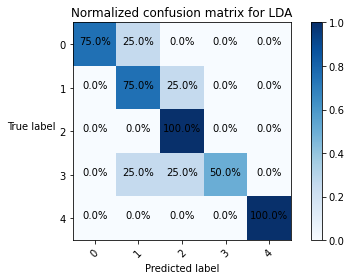

Fitting QDA to training set
QDA : done in 11.92ms.
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.33      0.50      0.40         4
           2       0.67      0.50      0.57         4
           3       0.00      0.00      0.00         4
           4       0.33      0.50      0.40         4

    accuracy                           0.45        20
   macro avg       0.39      0.45      0.41        20
weighted avg       0.39      0.45      0.41        20

Categorization Accuracy : 45.00%


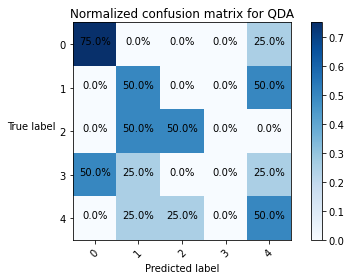

Fitting Perceptron to training set
Perceptron : done in 11.74ms.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.40      0.50      0.44         4
           2       0.67      1.00      0.80         4
           3       0.80      1.00      0.89         4
           4       1.00      1.00      1.00         4

    accuracy                           0.70        20
   macro avg       0.57      0.70      0.63        20
weighted avg       0.57      0.70      0.63        20

Categorization Accuracy : 70.00%


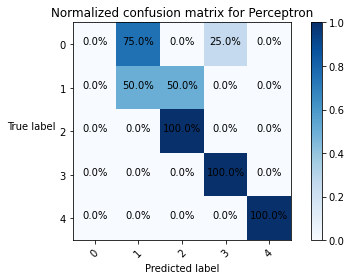

Fitting LSVM to training set
LSVM : done in 20.27ms.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       0.80      1.00      0.89         4
           3       1.00      0.75      0.86         4
           4       0.80      1.00      0.89         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20

Categorization Accuracy : 90.00%


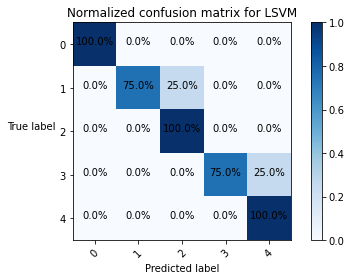

Fitting SVM to training set
SVM : done in 3.87ms.
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.50      0.67         4
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.89        20
weighted avg       0.92      0.90      0.89        20

Categorization Accuracy : 90.00%


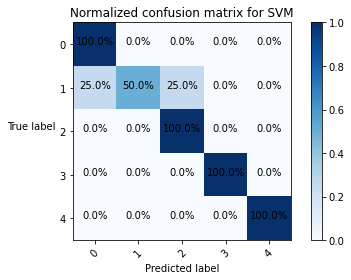

In [63]:
# Fitting some usual methods seen during the IMA205 courses
methods = {"LDA": LinearDiscriminantAnalysis(), "QDA": QuadraticDiscriminantAnalysis(), 'Perceptron':Perceptron(), 'LSVM':LinearSVC(), 'SVM':SVC()}
for name, method in methods.items():
    print(f"Fitting {name} to training set")
    t0 = time()
    method.fit(X_train, y_train)
    y_pred = method.predict(X_val)
    print(f"{name} : done in {format_duration(time()-t0)}.")

    print(classification_report(y_val, y_pred))

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_val, y_pred)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_map.keys(), normalize=True,
                          title=f'Normalized confusion matrix for {name}')
    plt.show()

Running cross validation for LDA...
LDA : done in 15.60ms.
LDA score: mean=71.0%, std=10.2%.

Running cross validation for QDA...
QDA : done in 8.10ms.
QDA score: mean=45.0%, std=16.1%.

Running cross validation for Perceptron...
Perceptron : done in 27.93ms.
Perceptron score: mean=66.0%, std=8.6%.

Running cross validation for LSVM...
Grid search for LSVM...
Best training params for LSVM: {'C': 0.05}
LSVM : done in 1.88s.
LSVM score: mean=81.0%, std=9.7%.

Running cross validation for SVM...
Grid search for SVM...
Best training params for SVM: {'C': 2.3, 'gamma': 0.1}
SVM : done in 1.83s.
SVM score: mean=82.0%, std=11.2%.



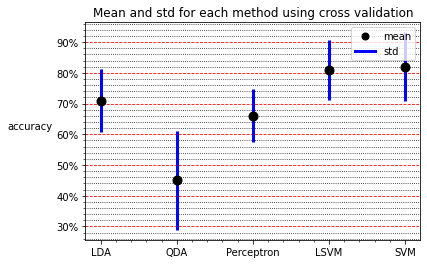

In [64]:
# Cross-validation for Model Assessment

scores = {}
methods = {'LDA': LinearDiscriminantAnalysis(), 'QDA':QuadraticDiscriminantAnalysis(),
            'Perceptron':Perceptron(), 'LSVM':LinearSVC(), 'SVM':SVC()}

# Define the hyperparameter distribution for each method
params = {
    'LSVM': {'C': [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,6e-1,7e-1,8e-1,9e-1,
                  1,1.5,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.5,4,4.5,5,6,7,8,9,1e1],},
    'SVM': {'C': [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1,6e-1,7e-1,8e-1,9e-1,
                  1,1.5,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.5,4,4.5,5,6,7,8,9,1e1], 
            'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.006, 0.007, 0.008, 0.009, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15,
                      0.2, 0.3, 0.4, 0.5, 1.,'auto','scale'],},
}

# Run randomized search for each method
for name, method in methods.items():
    print(f"Running cross validation for {name}...")
    t0 = time()
    if name == 'LSVM' or name == 'SVM':
        print(f'Grid search for {name}...')
        grid_search = GridSearchCV(method, params[name], cv=5, n_jobs=-1, scoring='accuracy')
        grid_search.fit(X, y)
        print(f"Best training params for {name}: {grid_search.best_params_}")
        if name == "SVM":
            method = SVC(**grid_search.best_params_)
        elif name == "LSVM":
            method = LinearSVC(**grid_search.best_params_)
    method_scores = cross_val_score(method, X, y, cv=5, scoring="accuracy")
    print(f"{name} : done in {format_duration(time()-t0)}.")
    scores[name] = {'scores': method_scores, 'mean': method_scores.mean(), 'std': method_scores.std()}
    print(f"{name} score: mean={scores[name]['mean']:.1%}, std={scores[name]['std']:.1%}.\n")

# Create a boxplot of the data
plt.figure()
means = [scores[name]['mean'] for name in methods.keys()]
stds = [scores[name]['std'] for name in methods.keys()]
plt.errorbar(methods.keys(), means, stds, fmt='ok', ms=9, lw=3, ecolor='b')

plt.ylabel('accuracy', rotation=0, ha='right')

# Legend
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', lw=0, ms=7, label='mean'),
                   Line2D([0], [0], color='b', lw=3, label='std'),]

plt.legend(handles=legend_elements)

plt.title("Mean and std for each method using cross validation")

# Show the grid and plot
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.gca().set_yticklabels([f'{val:,.0%}' for val in plt.gca().get_yticks()])
plt.show()

**NOTE:**  
SVM withg parameters `C=2.3` and `gamma=0.1` performs very well !

In [65]:
method = SVC(C=2.3, gamma=0.1)
method.fit(X, y)

# Predict
y_pred = method.predict(X_test)
print(y_pred)

[2 4 3 3 4 1 4 0 4 4 3 4 0 0 0 4 2 3 1 0 4 0 3 3 1 2 2 4 2 4 1 4 3 2 0 3 1
 3 2 4 2 1 1 1 4 2 0 1 1 1]


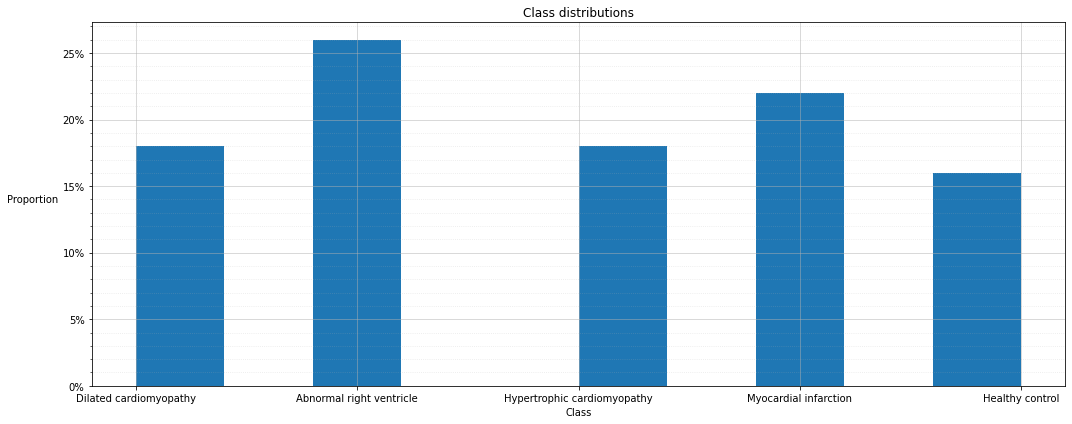

In [66]:
#Looking for class proportions in the prediction
class_labels = [class_map[prediction] for prediction in y_pred]

fig,ax=plt.subplots(figsize=(15,6))

major_ticks_y=np.linspace(0,1,21)
minor_ticks_y=np.linspace(0,1,101)

ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y,minor=True)
ax.set_title("Class distributions")
ax.grid(which="major",alpha=0.6)
ax.grid(which="minor",alpha=0.3,linestyle=':')
ax.hist(class_labels, weights=np.ones(len(class_labels)) / len(class_labels))
ax.set_xlabel('Class')
ax.set_ylabel('Proportion', rotation=0, ha='right')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
# Format x-axis tick labels as integers
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Set maximum number of ticks to 5
ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame({"Id": range(101, 151), "Category": y_pred})

# Write the dataframe to a CSV file
df.to_csv("Predictions.csv", index=False)